# TODOs
1. ### Lemmatize input
2. ### Replace CNNs with KAN-CNNs
3. ### Prune and test
4. ### B-spline Finetuning
5. ### CNN operates on whole embedded lvl - test on various depths (3, 9, 27, 81)
6. ### Deeper CNN - 1 + 3 + 5 gram feed into Deep CNN -> KAN
7. ### Data Augmentation

In [1]:
from fastkan import FastKAN as KAN

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from fastkan import FastKAN as KAN

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.datasets import IMDB
from transformers import GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv('./imdb.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
# Convert labels to binary
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 1447249.94it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [5]:
# Check for dataset imbalance
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
# Review token length
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 106508.27it/s]


,review,sentiment,label,token_length
0,One of the other reviewers has mentioned that ...,positive,1,307
1,A wonderful little production. <br /><br />The...,positive,1,162
2,I thought this was a wonderful way to spend ti...,positive,1,166
3,Basically there's a family where a little boy ...,negative,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230


In [7]:
data_pos = data[data['label'] == 1]
print("Positive review length")
data_pos['token_length'].describe()

Positive review length


count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [8]:
data_neg = data[data['label'] == 0]
print("Negative review length")
data_neg['token_length'].describe()

Negative review length


count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

In [9]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 
    words = word_tokenize(text)
    sent = [word for word in words if word not in stop_words]
    sent = ' '.join(sent)
    
    return sent

In [10]:
# Preprocessing
data['clean'] = data.review.progress_apply(preprocess_text)
data.head()

100%|██████████| 50000/50000 [00:23<00:00, 2147.85it/s]


,review,sentiment,label,token_length,clean
0,One of the other reviewers has mentioned that ...,positive,1,307,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,1,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,138,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,petter mattei love time money visually stunnin...


In [11]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [12]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    # Tokenize the text if necessary
    words = text.split()
    # Lemmatize each word in the text
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [13]:
data['lemma'] = data['clean'].progress_apply(lemmatize_text)

100%|██████████| 50000/50000 [00:15<00:00, 3131.11it/s]


In [14]:
for n in range(20):
    print(data['clean'][n])
    print(data['lemma'][n])

one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home many aryans muslims gangstas latinos christians italians irish scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare forget pretty pictures painted mainstream audiences forget charm forget romance oz mess around first episode ever saw struck nasty surreal say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards sold nickel inmates kill order get away well mannered middle class inmates turned prison bitches due lack street skil

In [15]:
tokenizer.pad_token = tokenizer.eos_token
max_l = 256
data['tokenized'] = data.lemma.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))

100%|██████████| 50000/50000 [00:31<00:00, 1573.59it/s]


In [16]:
# Check actual tokenized text len
data['ct_length'] = data.tokenized.progress_apply(lambda x: len(x))
data_pos = data[data['label'] == 1]
data_pos['ct_length'].describe()

100%|██████████| 50000/50000 [00:00<00:00, 1289166.74it/s]


count    25000.0
mean       256.0
std          0.0
min        256.0
25%        256.0
50%        256.0
75%        256.0
max        256.0
Name: ct_length, dtype: float64

In [17]:
# split the data
X = data.tokenized
y = data.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

# Convert to tensors
X_train_tensor = torch.tensor(X_train.tolist()).to(device)
X_test_tensor = torch.tensor(X_test.tolist()).to(device)
y_train_tensor = torch.tensor(y_train.tolist()).to(device)
y_test_tensor = torch.tensor(y_test.tolist()).to(device)

# Create Datasets - tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [65]:
# Batch the data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CustomCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Conv layers with different kernel sizes
        self.conv1 = nn.Conv2d(1, 256, (1, embed_dim), padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(256)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(0.25) 
        
        self.conv2 = nn.Conv2d(1, 256, (3, embed_dim), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(0.25) 
        
        self.conv3 = nn.Conv2d(1, 256, (5, embed_dim), padding=(2, 0))
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(0.25) 
        
        # Post PCAT Conv 1
        self.final_conv = nn.Conv2d(3 * 256, 1024, (3, 3), padding=(1, 1))
        
        self.bn_final = nn.BatchNorm2d(1024)
        self.pool_final = nn.MaxPool2d((2, 1))
        self.dropout_pcat1 = nn.Dropout(0.25)

        # Post PCAT Conv 2
        self.conv_pcat2 = nn.Conv2d(1024, 2048, (3, 3), padding=(1, 1))

        self.bn_pcat2 = nn.BatchNorm2d(2048)
        self.pool_pcat2 = nn.MaxPool2d((2, 1))
        self.dropout_pcat2 = nn.Dropout(0.25)

        # Post PCAT Conv 3
        self.conv_pcat3 = nn.Conv2d(2048, 4096, (3, 3), padding=(1, 1))

        self.bn_pcat3 = nn.BatchNorm2d(4096)
        self.pool_pcat3 = nn.MaxPool2d((4, 1))
        self.dropout_pcat3 = nn.Dropout(0.25)
        
        # Replace dense layers with FastKAN
        self.kan = KAN([32768, 256, 64, 8, 2], num_grids=8)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        
        # Embedding
        x = self.embedding(x)  # shape: (batch_size, seq_len, embed_dim)
        x = x.unsqueeze(1)  # shape: (batch_size, 1, seq_len, embed_dim)
        
        # Conv layer 1
        x1 = self.conv1(x)  # shape: (batch_size, 100, seq_len-0, 1)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = x1.squeeze(3)  # shape: (batch_size, 100, seq_len-0)
        x1 = self.pool1(x1)  # shape: (batch_size, 100, (seq_len-0)//2)
        x1 = self.dropout1(x1)
        
        # Conv layer 2
        x2 = self.conv2(x)  # shape: (batch_size, 100, seq_len-2, 1)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = x2.squeeze(3)  # shape: (batch_size, 100, seq_len-2)
        x2 = self.pool2(x2)  # shape: (batch_size, 100, (seq_len-2)//2)
        x2 = self.dropout2(x2)
        
        # Conv layer 3
        x3 = self.conv3(x)  # shape: (batch_size, 100, seq_len-4, 1)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = x3.squeeze(3)  # shape: (batch_size, 100, seq_len-4)
        x3 = self.pool3(x3)  # shape: (batch_size, 100, (seq_len-4)//2)
        x3 = self.dropout3(x3) 
        
        # Concatenate along the channel dimension
        x_cat = torch.cat((x1, x2, x3), dim=1)  # shape: (batch_size, 300, ...)
        x_cat = x_cat.unsqueeze(3)  # shape: (batch_size, 300, ..., 1)
        
        # PCAT1 Conv2D layer
        x_out = self.final_conv(x_cat)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_final(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_final(x_out)  # shape: (batch_size, 100, ..., 1)

        x_out = self.dropout_pcat1(x_out)

        # PCAT2 Conv2D layer
        x_out = self.conv_pcat2(x_out)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_pcat2(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat2(x_out)  # shape: (batch_size, 100, ..., 1)

        # PCAT3 Conv2D layer
        x_out = self.conv_pcat3(x_out)  # shape: (batch_size, 100, ..., 1)
        x_out = self.bn_pcat3(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_pcat3(x_out)  # shape: (batch_size, 100, ..., 1)
        
        # Flatten the tensor for the dense layer
        x_out = x_out.view(x_out.size(0), -1)  # shape: (batch_size, 100)
        x_out = self.dropout_pcat3(x_out)
        
        # Dense layer
        x_out = self.kan(x_out)  # shape: (batch_size, num_classes)
        
        return x_out

# Hyperparams
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 32  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = CustomCNN(vocab_size, embed_dim)
model.to(device)

CustomCNN(
  (embedding): Embedding(50257, 32)
  (conv1): Conv2d(1, 256, kernel_size=(1, 32), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(1, 256, kernel_size=(3, 32), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(1, 256, kernel_size=(5, 32), stride=(1, 1), padding=(2, 0))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (final_conv): Conv2d(768, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [67]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += calculate_accuracy(outputs, labels)
            total += labels.size(0)
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

In [68]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Learning rate decay
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Accuracy calculation
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Training loop
num_epochs = 20
model_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for texts, labels in pbar:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct_predictions += calculate_accuracy(outputs, labels)
            total_predictions += labels.size(0)
            
            accuracy = correct_predictions / total_predictions
            
            pbar.set_postfix(loss=total_loss/total_predictions, accuracy=accuracy)
    scheduler.step()

    model_history.append(evaluate(model, test_loader))
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy}')
    print(f'Val_Loss: {model_history[epoch][1]}, Val_Accuracy: {model_history[epoch][0]}')


Epoch 1/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.17it/s, accuracy=0.643, loss=0.0196]


Epoch 1, Loss: 0.6266585870027542, Accuracy: 0.6429
Val_Loss: 0.012779111218452453, Val_Accuracy: 0.811


Epoch 2/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.17it/s, accuracy=0.851, loss=0.0108]


Epoch 2, Loss: 0.3460489855647087, Accuracy: 0.8508
Val_Loss: 0.009595628872513771, Val_Accuracy: 0.8708


Epoch 3/20: 100%|██████████| 1250/1250 [02:21<00:00,  8.84it/s, accuracy=0.881, loss=0.00906]


Epoch 3, Loss: 0.2898919712007046, Accuracy: 0.881
Val_Loss: 0.008888646737486124, Val_Accuracy: 0.8868


Epoch 4/20: 100%|██████████| 1250/1250 [02:17<00:00,  9.06it/s, accuracy=0.897, loss=0.00806]


Epoch 4, Loss: 0.25792184869349005, Accuracy: 0.897325
Val_Loss: 0.008709985760599375, Val_Accuracy: 0.8851


Epoch 5/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.15it/s, accuracy=0.91, loss=0.0071]  


Epoch 5, Loss: 0.22719745344519615, Accuracy: 0.909625
Val_Loss: 0.00824160184338689, Val_Accuracy: 0.8938


Epoch 6/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.13it/s, accuracy=0.922, loss=0.00631]


Epoch 6, Loss: 0.2019139980494976, Accuracy: 0.9219
Val_Loss: 0.008601129570230842, Val_Accuracy: 0.8915


Epoch 7/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.18it/s, accuracy=0.932, loss=0.00554]


Epoch 7, Loss: 0.1773330542266369, Accuracy: 0.932325
Val_Loss: 0.010442678803578019, Val_Accuracy: 0.8785


Epoch 8/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.16it/s, accuracy=0.944, loss=0.00465]


Epoch 8, Loss: 0.1487010865777731, Accuracy: 0.944125
Val_Loss: 0.008845784372463823, Val_Accuracy: 0.8885


Epoch 9/20: 100%|██████████| 1250/1250 [02:16<00:00,  9.16it/s, accuracy=0.95, loss=0.00423]


Epoch 9, Loss: 0.1352363261654973, Accuracy: 0.950225
Val_Loss: 0.009276138403266668, Val_Accuracy: 0.8861


Epoch 10/20: 100%|██████████| 1250/1250 [02:17<00:00,  9.09it/s, accuracy=0.959, loss=0.00363]


Epoch 10, Loss: 0.11618958747684956, Accuracy: 0.958725
Val_Loss: 0.010343018204905092, Val_Accuracy: 0.8837


Epoch 11/20: 100%|██████████| 1250/1250 [02:15<00:00,  9.21it/s, accuracy=0.965, loss=0.00306]


Epoch 11, Loss: 0.09799068673625588, Accuracy: 0.965225
Val_Loss: 0.010576250268891453, Val_Accuracy: 0.886


Epoch 12/20: 100%|██████████| 1250/1250 [02:15<00:00,  9.20it/s, accuracy=0.969, loss=0.00271]


Epoch 12, Loss: 0.08687815817557275, Accuracy: 0.969025
Val_Loss: 0.011142691340483724, Val_Accuracy: 0.8823


Epoch 13/20: 100%|██████████| 1250/1250 [02:15<00:00,  9.23it/s, accuracy=0.975, loss=0.00233]


Epoch 13, Loss: 0.07450395207386463, Accuracy: 0.97475
Val_Loss: 0.011790983657725155, Val_Accuracy: 0.8808


Epoch 14/20: 100%|██████████| 1250/1250 [02:15<00:00,  9.21it/s, accuracy=0.979, loss=0.00196]


Epoch 14, Loss: 0.06268686338998378, Accuracy: 0.978775
Val_Loss: 0.0129299929831177, Val_Accuracy: 0.8799


Epoch 15/20: 100%|██████████| 1250/1250 [02:11<00:00,  9.49it/s, accuracy=0.982, loss=0.00166]


Epoch 15, Loss: 0.05296235254146159, Accuracy: 0.982475
Val_Loss: 0.013631305577605963, Val_Accuracy: 0.8783


Epoch 16/20: 100%|██████████| 1250/1250 [02:09<00:00,  9.62it/s, accuracy=0.986, loss=0.00138]


Epoch 16, Loss: 0.04428623024197295, Accuracy: 0.9859
Val_Loss: 0.014283572800457478, Val_Accuracy: 0.8786


Epoch 17/20: 100%|██████████| 1250/1250 [02:09<00:00,  9.62it/s, accuracy=0.988, loss=0.00124]


Epoch 17, Loss: 0.03980530981263146, Accuracy: 0.98755
Val_Loss: 0.014582053928263486, Val_Accuracy: 0.8734


Epoch 18/20: 100%|██████████| 1250/1250 [02:15<00:00,  9.25it/s, accuracy=0.989, loss=0.00111]


Epoch 18, Loss: 0.03536167647452094, Accuracy: 0.9892
Val_Loss: 0.01476871321508661, Val_Accuracy: 0.8796


Epoch 19/20: 100%|██████████| 1250/1250 [02:12<00:00,  9.41it/s, accuracy=0.99, loss=0.000989]


Epoch 19, Loss: 0.031651416193181646, Accuracy: 0.9903
Val_Loss: 0.015047402048809454, Val_Accuracy: 0.8767


Epoch 20/20: 100%|██████████| 1250/1250 [02:12<00:00,  9.46it/s, accuracy=0.992, loss=0.000838]


Epoch 20, Loss: 0.026808421564474702, Accuracy: 0.992275
Val_Loss: 0.01507362775877118, Val_Accuracy: 0.8786


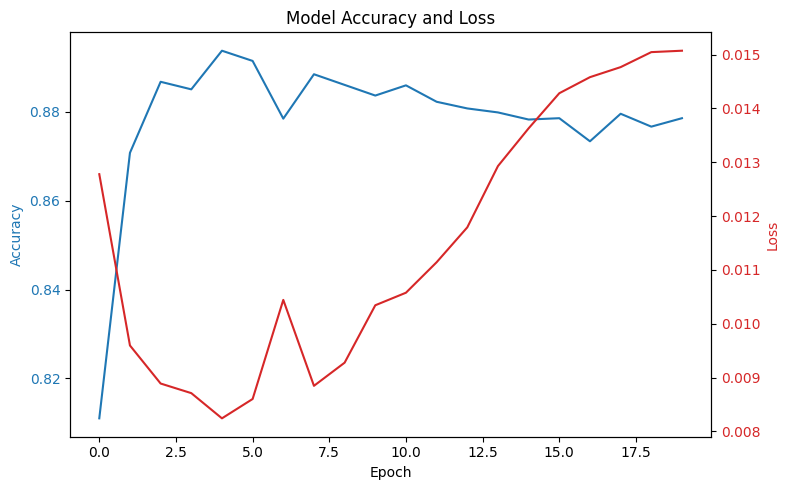

In [69]:
import matplotlib.pyplot as plt

#Plot val acc and loss
accuracy = [entry[0] for entry in model_history]
loss = [entry[1] for entry in model_history]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy on primary y
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(accuracy, label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot the loss on secondary y
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(loss, label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Model Accuracy and Loss')
fig.tight_layout()
plt.show()

In [64]:
del model

import gc         # garbage collect library
gc.collect()
torch.cuda.empty_cache() 

In [34]:
# OLD
class SentimentCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(SentimentCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # convolutional layers with batch Normalization
        self.conv1 = nn.Conv2d(1, 100, (1, embed_dim), padding=(0, 0))  # 1-gram
        self.bn1 = nn.BatchNorm2d(100)
        
        self.conv2 = nn.Conv2d(1, 100, (3, embed_dim), padding=(1, 0))  # 3-gram
        self.bn2 = nn.BatchNorm2d(100)
        
        self.conv3 = nn.Conv2d(1, 100, (5, embed_dim), padding=(2, 0))  # 5-gram
        self.bn3 = nn.BatchNorm2d(100)
        
        self.dropout = nn.Dropout(0.5)

        self.conv_pcat1 = nn.Conv2d(1, 200, (3, 3), padding=(0,0))
        self.bn_pcat1 = nn.BatchNorm2d(200)
        
        
        # Replace dense layers with FastKAN
        self.kan = KAN([37500, 512, 128, num_class], num_grids=4)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)  # Add channel dimension
        
        conv1_out = F.relu(self.bn1(self.conv1(embedded))).squeeze(3)
        conv2_out = F.relu(self.bn2(self.conv2(embedded))).squeeze(3)
        conv3_out = F.relu(self.bn3(self.conv3(embedded))).squeeze(3)
        
        pooled1 = F.max_pool1d(conv1_out, 2).squeeze(2)
        pooled2 = F.max_pool1d(conv2_out, 2).squeeze(2)
        pooled3 = F.max_pool1d(conv3_out, 2).squeeze(2)

        cat = torch.cat((pooled1, pooled2, pooled3), 0)

        conv_pcat1_out = F.relu(self.bn_pcat1(self.conv_pcat1(cat))).squeeze(3)
        pooled_pcat1 = F.max_pool2d(conv1_out, 2).squeeze(2)
        
        #cat = cat.view(cat.size(0), -1)
        dropout = self.dropout(pooled_pcat1)
        
        # Use kan for final classification
        out = self.kan(dropout)
        return out


# Hyperparams
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 128  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = SentimentCNNModel(vocab_size, embed_dim, num_class)
model.to(device)

SentimentCNNModel(
  (embedding): Embedding(50257, 128)
  (conv1): Conv2d(1, 100, kernel_size=(1, 128), stride=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 100, kernel_size=(3, 128), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(1, 100, kernel_size=(5, 128), stride=(1, 1), padding=(2, 0))
  (bn3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv_pcat1): Conv2d(1, 200, kernel_size=(3, 3), stride=(1, 1))
  (bn_pcat1): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (kan): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((37500,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=150000, out_feat

In [53]:
# 89.0% Val
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super(CustomCNN, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Conv layers with different kernel sizes
        self.conv1 = nn.Conv2d(1, 100, (1, embed_dim), padding=(0, 0))
        self.bn1 = nn.BatchNorm2d(100)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv2d(1, 100, (3, embed_dim), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(100)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv2d(1, 100, (5, embed_dim), padding=(2, 0))
        self.bn3 = nn.BatchNorm2d(100)
        self.pool3 = nn.MaxPool1d(2)
        
        # Final Conv2D layer after concatenation
        self.final_conv = nn.Conv2d(3 * 100, 500, (3, 3), padding=(1, 1))
        
        # Additional layers
        self.bn_final = nn.BatchNorm2d(100)
        self.pool_final = nn.MaxPool2d((2, 1))
        self.dropout = nn.Dropout(0.65)
        
        # Dense layer
        #self.fc = nn.Linear(100, num_classes)
        
        # Replace dense layers with FastKAN
        self.kan = KAN([32000, 512, 128, 2], num_grids=4)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len)
        
        # Embedding
        x = self.embedding(x)  # shape: (batch_size, seq_len, embed_dim)
        x = x.unsqueeze(1)  # shape: (batch_size, 1, seq_len, embed_dim)
        
        # Conv layer 1
        x1 = self.conv1(x)  # shape: (batch_size, 100, seq_len-0, 1)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)
        x1 = x1.squeeze(3)  # shape: (batch_size, 100, seq_len-0)
        x1 = self.pool1(x1)  # shape: (batch_size, 100, (seq_len-0)//2)
        
        # Conv layer 2
        x2 = self.conv2(x)  # shape: (batch_size, 100, seq_len-2, 1)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)
        x2 = x2.squeeze(3)  # shape: (batch_size, 100, seq_len-2)
        x2 = self.pool2(x2)  # shape: (batch_size, 100, (seq_len-2)//2)
        
        # Conv layer 3
        x3 = self.conv3(x)  # shape: (batch_size, 100, seq_len-4, 1)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)
        x3 = x3.squeeze(3)  # shape: (batch_size, 100, seq_len-4)
        x3 = self.pool3(x3)  # shape: (batch_size, 100, (seq_len-4)//2)
        
        # Concatenate along the channel dimension
        x_cat = torch.cat((x1, x2, x3), dim=1)  # shape: (batch_size, 300, ...)
        x_cat = x_cat.unsqueeze(3)  # shape: (batch_size, 300, ..., 1)
        
        # Final Conv2D layer
        x_out = self.final_conv(x_cat)  # shape: (batch_size, 100, ..., 1)
        #x_out = self.bn_final(x_out)
        x_out = F.relu(x_out)
        x_out = self.pool_final(x_out)  # shape: (batch_size, 100, ..., 1)
        
        # Flatten the tensor for the dense layer
        x_out = x_out.view(x_out.size(0), -1)  # shape: (batch_size, 100)
        x_out = self.dropout(x_out)
        
        # Dense layer
        x_out = self.kan(x_out)  # shape: (batch_size, num_classes)
        
        return x_out

# Hyperparams
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 128  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = CustomCNN(vocab_size, embed_dim)
model.to(device)

CustomCNN(
  (embedding): Embedding(50257, 128)
  (conv1): Conv2d(1, 100, kernel_size=(1, 128), stride=(1, 1))
  (bn1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(1, 100, kernel_size=(3, 128), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(1, 100, kernel_size=(5, 128), stride=(1, 1), padding=(2, 0))
  (bn3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (final_conv): Conv2d(300, 500, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_final): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_final): MaxPool2